In [1]:
from liblet import Grammar, Derivation, ProductionGraph, show_calls, iter2table

# Eliminazione della ricorsione

In [2]:
# ricorsiva

"""
E -> E + T | E - T | T
T -> t
""";

In [3]:
# non ricorsiva

"""
E -> Eh Ets | Eh
Eh -> T
Ets -> Et Ets | Et
Et -> + T | - T
T -> t
""";

In [4]:
# prefix-free

G = Grammar.from_string("""
E -> Eh Ets | Eh #
Eh -> T
Ets -> Et Ets | Et #
Et -> + T | - T
T -> t
""")
G

# Ets => Et^+ #
# E => Eh Ets * #

Grammar(N={E, Eh, Et, Ets, T}, T={#, +, -, t}, P=(E -> Eh Ets, E -> Eh #, Eh -> T, Ets -> Et Ets, Ets -> Et #, Et -> + T, Et -> - T, T -> t), S=E)

# Parser ricorsivo discendente

In [5]:
@show_calls(True)
def match(X, rest): # returns: succ, rest

    if X in G.T:
        
        if rest and rest[0] == X: return True, rest[1:]
        return False, rest

    elif X == 'T': # T -> t

        return match('t', rest)

    elif X == 'Eh': # Eh -> T

        return match('T', rest)
    
    elif X == 'Et': # Et -> + T | - T

        s, r = match('+', rest)
        if s: return match('T', r)
        s, r = match('-', rest)
        if s: return match('T', r)
        return False, rest        

    elif X == 'Ets': # Ets -> Et Ets | Et #

        s0, r0 = match('Et', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1
            return match('Ets', r0)
        return False, rest        
    
    elif X == 'E': # E -> Eh Ets | Eh #

        s0, r0 = match('Eh', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1
            return match('Ets', r0)
        return False, rest        


In [6]:
match('E', 't+t#')

┌match('E', 't+t#')
│┌match('Eh', 't+t#')
││┌match('T', 't+t#')
│││┌match('t', 't+t#')
│││└─ (True, '+t#')
││└─ (True, '+t#')
│└─ (True, '+t#')
│┌match('#', '+t#')
│└─ (False, '+t#')
│┌match('Ets', '+t#')
││┌match('Et', '+t#')
│││┌match('+', '+t#')
│││└─ (True, 't#')
│││┌match('T', 't#')
││││┌match('t', 't#')
││││└─ (True, '#')
│││└─ (True, '#')
││└─ (True, '#')
││┌match('#', '#')
││└─ (True, '')
│└─ (True, '')
└─ (True, '')


(True, '')

## Ricostruire l'albero di parsing

In [7]:
iter2table(G.P)

In [8]:
@show_calls(True)
def match(X, rest): # returns: succ, rest, lm_steps

    if X in G.T:
        
        if rest and rest[0] == X: return True, rest[1:]
        return False, rest

    elif X == 'T':

        s, r = match('t', rest)
        if s: return True, r, [7]
        
    elif X == 'Eh':
        
        s, r, p = match('T', rest)
        if s: return True, r, [2] + p

    elif X == 'Et':
        
        s, r = match('+', rest)
        if s:
            s, r, p = match('T', r)
            if s: return True, r, [5] + p
        s, r = match('-', rest)
        if s: 
            s, r, p = match('T', r)
            if s: return True, r, [6] + p
            
    elif X == 'Ets':
        
        s0, r0, p0 = match('Et', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1, [4] + p0
            s2, r2, p2 = match('Ets', r0)
            if s2: return True, r2, [3] + p0 + p2

    elif X == 'E':

        s0, r0, p0 = match('Eh', rest)
        if s0:
            s1, r1 = match('#', r0)
            if s1: return True, r1, [1] + p0
            s2, r2, p2 = match('Ets', r0)
            if s2: return True, r2, [0] + p0 + p2

    return False, rest, []        

In [9]:
_, _, lm_steps = match('E', 't+t+t#')

┌match('E', 't+t+t#')
│┌match('Eh', 't+t+t#')
││┌match('T', 't+t+t#')
│││┌match('t', 't+t+t#')
│││└─ (True, '+t+t#')
││└─ (True, '+t+t#', [7])
│└─ (True, '+t+t#', [2, 7])
│┌match('#', '+t+t#')
│└─ (False, '+t+t#')
│┌match('Ets', '+t+t#')
││┌match('Et', '+t+t#')
│││┌match('+', '+t+t#')
│││└─ (True, 't+t#')
│││┌match('T', 't+t#')
││││┌match('t', 't+t#')
││││└─ (True, '+t#')
│││└─ (True, '+t#', [7])
││└─ (True, '+t#', [5, 7])
││┌match('#', '+t#')
││└─ (False, '+t#')
││┌match('Ets', '+t#')
│││┌match('Et', '+t#')
││││┌match('+', '+t#')
││││└─ (True, 't#')
││││┌match('T', 't#')
│││││┌match('t', 't#')
│││││└─ (True, '#')
││││└─ (True, '#', [7])
│││└─ (True, '#', [5, 7])
│││┌match('#', '#')
│││└─ (True, '')
││└─ (True, '', [4, 5, 7])
│└─ (True, '', [3, 5, 7, 4, 5, 7])
└─ (True, '', [0, 2, 7, 3, 5, 7, 4, 5, 7])


[0, 2, 7, 3, 5, 7, 4, 5, 7]


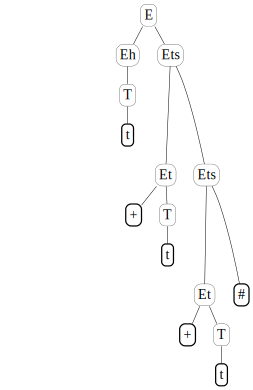

In [10]:
print(lm_steps)
d = Derivation(G)
for s in lm_steps: d = d.leftmost(s)
ProductionGraph(d)

## Una grammatica per somme e prodotti (non prefix-free)

In [11]:
# ricorsiva

"""
E -> E + T | E - T | T
T -> T * F | T / F | F
F -> f
""";

In [12]:
# non ricorsiva

Gsp = Grammar.from_string("""
E -> Eh Ets | Eh
Eh -> T
Ets -> Et Ets | Et
Et -> + T | - T
T -> Th Tts | Th
Th -> F
Tts -> Tt Tts | Tt
Tt -> * F | / F
F -> f
""")

In [13]:
@show_calls(True)
def match(X, rest):

    if X in Gsp.T:
        
        if rest and rest[0] == X: return True, rest[1:]
        return False, rest

    elif X == 'F':
        
        return match('f', rest)

    elif X == 'Th':

        return match('F', rest)
    
    elif X == 'Tt':

        s, r = match('*', rest)
        if s: return match('F', r)
        s, r = match('/', rest)
        if s: return match('F', r)
        
    elif X == 'Tts':

        s0, r0 = match('Tt', rest)
        if s0 and r0: 
            s1, r1 = match('Tts', r0)
            if s1: return s1, r1
        return s0, r0
    
    elif X == 'T':

        s0, r0 = match('Th', rest)
        if s0 and r0: 
            s1, r1 = match('Tts', r0)
            if s1: return s1, r1
        return s0, r0
    
    elif X == 'Eh':

        return match('T', rest)
    
    elif X == 'Et':

        s, r = match('+', rest)
        if s: return match('T', r)
        s, r = match('-', rest)
        if s: return match('T', r)
        
    elif X == 'Ets':

        s0, r0 = match('Et', rest)
        if s0 and r0: 
            s1, r1 = match('Ets', r0)
            if s1: return s1, r1
        return s0, r0
    
    elif X == 'E':

        s0, r0 = match('Eh', rest)
        if s0 and r0: 
            s1, r1 = match('Ets', r0)
            if s1: return s1, r1
        return s0, r0
    
    return False, rest        

In [14]:
match('E', 'f*f+f*f')

┌match('E', 'f*f+f*f')
│┌match('Eh', 'f*f+f*f')
││┌match('T', 'f*f+f*f')
│││┌match('Th', 'f*f+f*f')
││││┌match('F', 'f*f+f*f')
│││││┌match('f', 'f*f+f*f')
│││││└─ (True, '*f+f*f')
││││└─ (True, '*f+f*f')
│││└─ (True, '*f+f*f')
│││┌match('Tts', '*f+f*f')
││││┌match('Tt', '*f+f*f')
│││││┌match('*', '*f+f*f')
│││││└─ (True, 'f+f*f')
│││││┌match('F', 'f+f*f')
││││││┌match('f', 'f+f*f')
││││││└─ (True, '+f*f')
│││││└─ (True, '+f*f')
││││└─ (True, '+f*f')
││││┌match('Tts', '+f*f')
│││││┌match('Tt', '+f*f')
││││││┌match('*', '+f*f')
││││││└─ (False, '+f*f')
││││││┌match('/', '+f*f')
││││││└─ (False, '+f*f')
│││││└─ (False, '+f*f')
││││└─ (False, '+f*f')
│││└─ (True, '+f*f')
││└─ (True, '+f*f')
│└─ (True, '+f*f')
│┌match('Ets', '+f*f')
││┌match('Et', '+f*f')
│││┌match('+', '+f*f')
│││└─ (True, 'f*f')
│││┌match('T', 'f*f')
││││┌match('Th', 'f*f')
│││││┌match('F', 'f*f')
││││││┌match('f', 'f*f')
││││││└─ (True, '*f')
│││││└─ (True, '*f')
││││└─ (True, '*f')
││││┌match('Tts', '*f')
│││││┌match('T

(True, '')

# Un generatore di parser

In [15]:
# prima alternativa per Ets

"Ets -> Et Ets"

def Ets_alt0(rest):
    succ, rest = parse('Et', rest)
    if not succ: return False, rest
    succ, rest = parse('Ets', rest)
    if not succ: return False, rest
    return True, rest

In [16]:
# seconda alternativa per Ets

"Ets -> Et #"

def Ets_alt1(rest):
    succ, rest = parse('Et', rest)
    if not succ: return False, rest
    succ, rest = match('#', rest)
    if not succ: return False, rest
    return True, rest

In [17]:
# parse di Ets

"Ets -> Et Ets | Et #"

def match(N, rest):
    if N == 'Ets':
        succ_alt, rest_alt = Ets_alt0(rest)
        if succ_alt: return True, rest_alt
        succ_alt, rest_alt = Ets_alt1(rest)
        if succ_alt: return True, rest_alt
        return False, rest

In [18]:
def make_match_source(G):
    code_ifs = []
    code_defs = []
    code_ifs = ['\tif X in {}:\n\t\tif rest and rest[0] == X: return True, rest[1:]\n\t\treturn False, rest'.format(G.T)]
    for A in G.N:
        code_ifs.append("\tif X == '{}':".format(A))
        for n, α in enumerate(G.alternatives(A)):
            code_defs.append("\tdef {}_alt{}(rest):".format(A, n, A, n))
            for X in α:
                if X in G.T:
                    code_defs.append("\t\tsucc, rest = match('{}', rest)".format(X))
                    code_defs.append("\t\tif not succ: return False, rest")
                else:
                    code_defs.append("\t\tsucc, rest = match('{}', rest)".format(X))
                    code_defs.append("\t\tif not succ: return False, rest")
            code_defs.append("\t\treturn True, rest")
            code_ifs.append("\t\tsucc_alt, rest_alt = {}_alt{}(rest)".format(A, n))
            code_ifs.append("\t\tif succ_alt: return True, rest_alt".format(A, n))
        code_ifs.append("\t\treturn False, rest")
    return '@show_calls(True)\ndef match(X, rest):\n' + '\n'.join(code_defs) + '\n' + '\n'.join(code_ifs)

In [19]:
source = make_match_source(G)
print(source)

@show_calls(True)
def match(X, rest):
	def Eh_alt0(rest):
		succ, rest = match('T', rest)
		if not succ: return False, rest
		return True, rest
	def Ets_alt0(rest):
		succ, rest = match('Et', rest)
		if not succ: return False, rest
		succ, rest = match('Ets', rest)
		if not succ: return False, rest
		return True, rest
	def Ets_alt1(rest):
		succ, rest = match('Et', rest)
		if not succ: return False, rest
		succ, rest = match('#', rest)
		if not succ: return False, rest
		return True, rest
	def Et_alt0(rest):
		succ, rest = match('+', rest)
		if not succ: return False, rest
		succ, rest = match('T', rest)
		if not succ: return False, rest
		return True, rest
	def Et_alt1(rest):
		succ, rest = match('-', rest)
		if not succ: return False, rest
		succ, rest = match('T', rest)
		if not succ: return False, rest
		return True, rest
	def T_alt0(rest):
		succ, rest = match('t', rest)
		if not succ: return False, rest
		return True, rest
	def E_alt0(rest):
		succ, rest = match('Eh', rest)
		if 

In [20]:
# "trucco" Python per ottenere una funzione dato il suo sorgente

def make_match(source):
    glb = {'show_calls': show_calls}
    exec(source, glb)
    return glb['match']       

In [21]:
match = make_match(source)

match('E', 't#')

┌match('E', 't#')
│┌match('Eh', 't#')
││┌match('T', 't#')
│││┌match('t', 't#')
│││└─ (True, '#')
││└─ (True, '#')
│└─ (True, '#')
│┌match('Ets', '#')
││┌match('Et', '#')
│││┌match('+', '#')
│││└─ (False, '#')
│││┌match('-', '#')
│││└─ (False, '#')
││└─ (False, '#')
││┌match('Et', '#')
│││┌match('+', '#')
│││└─ (False, '#')
│││┌match('-', '#')
│││└─ (False, '#')
││└─ (False, '#')
│└─ (False, '#')
│┌match('Eh', 't#')
││┌match('T', 't#')
│││┌match('t', 't#')
│││└─ (True, '#')
││└─ (True, '#')
│└─ (True, '#')
│┌match('#', '#')
│└─ (True, '')
└─ (True, '')


(True, '')

## Caso concreto non prefix-free

In [22]:
# non prefix-free

G = Grammar.from_string("""
S -> a | B
B -> a b
""")
G

Grammar(N={B, S}, T={a, b}, P=(S -> a, S -> B, B -> a b), S=S)

In [23]:
source = make_match_source(G)
print(source)

@show_calls(True)
def match(X, rest):
	def S_alt0(rest):
		succ, rest = match('a', rest)
		if not succ: return False, rest
		return True, rest
	def S_alt1(rest):
		succ, rest = match('B', rest)
		if not succ: return False, rest
		return True, rest
	def B_alt0(rest):
		succ, rest = match('a', rest)
		if not succ: return False, rest
		succ, rest = match('b', rest)
		if not succ: return False, rest
		return True, rest
	if X in frozenset({'b', 'a'}):
		if rest and rest[0] == X: return True, rest[1:]
		return False, rest
	if X == 'S':
		succ_alt, rest_alt = S_alt0(rest)
		if succ_alt: return True, rest_alt
		succ_alt, rest_alt = S_alt1(rest)
		if succ_alt: return True, rest_alt
		return False, rest
	if X == 'B':
		succ_alt, rest_alt = B_alt0(rest)
		if succ_alt: return True, rest_alt
		return False, rest


In [24]:
match = make_match(source)
match('S', 'ab')

┌match('S', 'ab')
│┌match('a', 'ab')
│└─ (True, 'b')
└─ (True, 'b')


(True, 'b')

# Homework

* Modificate `make_match_source` perché restituisca l'elenco di produzioni 
  della derivazione *leftmost* corrisondente al parsing effettuato? 
  
* Si può modificate `make_match_source` perché funzioni anche per la grammatica 
  non *prefix-free* di somme e moltipliche?